<a href="https://colab.research.google.com/github/eswistak88/DataMiningProject/blob/sabiya/Ensembles_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [88]:
import os
import re
import glob
import struct
from os import makedirs

import numpy as np
from numpy import asarray
from numpy import zeros
from nltk.stem.porter import *


import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras import Model
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Input, Reshape, Conv2D, MaxPool2D, Dense, Dropout, Flatten, Embedding, Concatenate, Conv1D
from keras.metrics import CategoricalAccuracy, Precision, Recall
from keras import regularizers
from keras import backend as K
from keras.models import load_model

import sklearn
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import StackingClassifier

import matplotlib.pyplot as plt


Load the Dataset


In [2]:
os.chdir("/content/drive/MyDrive/twit/train")

extension = 'csv'
all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

#combine all files in the list
combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
#export to csv
combined_csv.to_csv( "combined_csv.csv", index=False, encoding='utf-8-sig')

In [3]:
names = ['TweetID', 'Sentiment', 'Tweet']

train = pd.read_csv('/content/drive/MyDrive/twit/train/combined_csv.csv')

train.head()

,Column1,Column2,Column3
0,2.641840e+17,positive,Gas by my house hit $3.39!!!! I\u2019m going t...
1,2.634050e+17,negative,Theo Walcott is still shit\u002c watch Rafa an...
2,2.621630e+17,negative,its not that I\u2019m a GSP fan\u002c i just h...
3,2.642490e+17,negative,Iranian general says Israel\u2019s Iron Dome c...
4,2.626820e+17,neutral,Tehran\u002c Mon Amour: Obama Tried to Establi...


Data Preprocessing

In [4]:
def remove_pattern(input_txt, pattern):
  r = re.findall(pattern, input_txt)
  for i in r:
    input_txt = re.sub(i, '', input_txt)        
  return input_txt

def clean_tweets(frame, column_name):
  frame = frame.drop_duplicates().reset_index(drop=True) #remove duplicate rows
  frame['Tweet_Clean_Text'] = np.vectorize(remove_pattern)(frame[column_name], "RT @[\w]*:") #remove twitter return handle
  frame.Tweet_Clean_Text = np.vectorize(remove_pattern)(frame['Tweet_Clean_Text'], "@[\w]*") #remove twitter handle
  frame.Tweet_Clean_Text = np.vectorize(remove_pattern)(frame['Tweet_Clean_Text'], "https?://[A-Za-z0-9./]*") #remove URLs
  frame.Tweet_Clean_Text = frame.Tweet_Clean_Text.str.replace("[^a-zA-Z#]", " ") #remove special characters except for #
  frame.Tweet_Clean_Text = frame.Tweet_Clean_Text.replace('\s+', ' ', regex=True) #remove extra spaces in between words

  return frame

In [5]:
train_set = clean_tweets(train, 'Column3')
train_set.head()

,Column1,Column2,Column3,Tweet_Clean_Text
0,2.641840e+17,positive,Gas by my house hit $3.39!!!! I\u2019m going t...,Gas by my house hit I u m going to Chapel Hill...
1,2.634050e+17,negative,Theo Walcott is still shit\u002c watch Rafa an...,Theo Walcott is still shit u c watch Rafa and ...
2,2.621630e+17,negative,its not that I\u2019m a GSP fan\u002c i just h...,its not that I u m a GSP fan u c i just hate N...
3,2.642490e+17,negative,Iranian general says Israel\u2019s Iron Dome c...,Iranian general says Israel u s Iron Dome can ...
4,2.626820e+17,neutral,Tehran\u002c Mon Amour: Obama Tried to Establi...,Tehran u c Mon Amour Obama Tried to Establish ...


In [6]:
train_set["Sentiment_Value"] = train_set["Column2"].map({"neutral": 0, "positive": 1, "negative": 2})
label = to_categorical(train_set["Sentiment_Value"], 3)
train_set

,Column1,Column2,Column3,Tweet_Clean_Text,Sentiment_Value
0,2.641840e+17,positive,Gas by my house hit $3.39!!!! I\u2019m going t...,Gas by my house hit I u m going to Chapel Hill...,1
1,2.634050e+17,negative,Theo Walcott is still shit\u002c watch Rafa an...,Theo Walcott is still shit u c watch Rafa and ...,2
2,2.621630e+17,negative,its not that I\u2019m a GSP fan\u002c i just h...,its not that I u m a GSP fan u c i just hate N...,2
3,2.642490e+17,negative,Iranian general says Israel\u2019s Iron Dome c...,Iranian general says Israel u s Iron Dome can ...,2
4,2.626820e+17,neutral,Tehran\u002c Mon Amour: Obama Tried to Establi...,Tehran u c Mon Amour Obama Tried to Establish ...,0
...,...,...,...,...,...
49710,6.820000e+17,neutral,@ShaquilleHoNeal from what I think you're aski...,from what I think you re asking in no order F...,0
49711,6.820000e+17,positive,"Iran ranks 1st in liver surgeries, Allah bless...",Iran ranks st in liver surgeries Allah bless t...,1
49712,6.820000e+17,neutral,Hours before he arrived in Saudi Arabia on Tue...,Hours before he arrived in Saudi Arabia on Tue...,0
49713,6.820000e+17,negative,@VanityFair Alex Kim Kardashian worth how to ...,Alex Kim Kardashian worth how to love Kim Kar...,2


In [7]:
y_labels = train_set['Sentiment_Value']
y_labels.shape

(49715,)

In [8]:
train['l'] = train_set['Tweet_Clean_Text'].apply(lambda x: len(str(x).split(' ')))
print("mean length of sentence: " + str(train.l.mean()))
print("max length of sentence: " + str(train.l.max()))
print("std dev length of sentence: " + str(train.l.std()))

mean length of sentence: 20.210278587951322
max length of sentence: 47.0
std dev length of sentence: 5.2648519182168725


In [9]:
sequence_length = 47 #using the maximum length 

In [10]:
max_features = 2500
tokenizer = Tokenizer(num_words=max_features, split=' ', oov_token='<unw>')
tokenizer.fit_on_texts(train_set['Tweet_Clean_Text'].values)

X = tokenizer.texts_to_sequences(train_set['Tweet_Clean_Text'].values)
X = pad_sequences(X, sequence_length)
x_train = X

print("training size " + str(len(x_train)))

voc_size = len(tokenizer.word_index) + 1
print("Vocab size: ", voc_size)
print("Input shape: ", x_train.shape)
print("Y_shape: " , y_labels.shape)

training size 49715
Vocab size:  42660
Input shape:  (49715, 47)
Y_shape:  (49715,)


Spliting the dataset

In [11]:
X_train, X_dev, Y_train, Y_dev = train_test_split(x_train, y_labels, test_size=0.15, shuffle=True, random_state=10)

GloVe Embedding

In [12]:
embeddings_index = dict()
f = open('/content/drive/MyDrive/glove.twitter.27B/glove.twitter.27B.200d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 1193514 word vectors.


In [60]:
embedding_dim = 200
embedding_matrix = np.zeros((voc_size, embedding_dim))
for word, i in tokenizer.word_index.items():
	embedding_vector = embeddings_index.get(word)
	if embedding_vector is not None:
		embedding_matrix[i] = embedding_vector

**Stacked CNN Predictions Ensemble**

In [14]:
import seaborn as sns
from sklearn import metrics

THRESHOLD = 0.35

class EpochMetricsCallback(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.f1s = []
        self.precisions = []
        self.recalls = []
        
    def on_epoch_end(self, epoch, logs={}):
        predictions = self.model.predict(self.validation_data[0])
        predictions = (predictions > THRESHOLD).astype(int)
        predictions = np.asarray(predictions)
        targets = self.validation_data[1]
        f1 = metrics.f1_score(targets, predictions)
        precision = metrics.precision_score(targets, predictions)
        recall = metrics.recall_score(targets, predictions)

        print(" - F1 score: {0:.4f}, Precision: {1:.4f}, Recall: {2:.4f}"
              .format(f1, precision, recall))
        self.f1s.append(f1)
        self.precisions.append(precision)
        self.recalls.append(recall)
        return
    
def display_model_history(history):
    data = pd.DataFrame(data={'Train': history.history['loss'], 'Test': history.history['val_loss']})
    ax = sns.lineplot(data=data, palette="pastel", linewidth=2.5, dashes=False)
    ax.set(xlabel='Epoch', ylabel='Loss', title='Loss')
    plt.show()

def display_model_epoch_metrics(epoch_callback):
    fig, axes = plt.subplots(1, 3, figsize = (15, 5), sharey=False)
    a1, a2, a3 = axes
    
    a1.set_title('F1')
    a1.set(xlabel='Epoch', title='F1')
    sns.lineplot(data=pd.DataFrame(data={'F1': epoch_callback.f1s}),
                 palette="pastel", linewidth=2.5, dashes=False, ax=a1, legend=False)

    a2.set_title('Precision')
    a2.set(xlabel='Epoch', title='Precision')
    sns.lineplot(data=pd.DataFrame(data={'Precision': epoch_callback.precisions}),
                 palette="pastel", linewidth=2.5, dashes=False, ax=a2, legend=False)

    a3.set_title('Recall')
    a3.set(xlabel='Epoch', title='Recall')
    sns.lineplot(data=pd.DataFrame(data={'Recall': epoch_callback.recalls}),
                 palette="pastel", linewidth=2.5, dashes=False, ax=a3, legend=False)

    plt.show()

In [15]:
Y_train_cat = to_categorical(Y_train, 3)
Y_dev_cat = to_categorical(Y_dev, 3)

In [16]:
def recall_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    recall_score.__name__ = 'recall'
    return recall

def precision_score(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    precision_score.__name__ = 'precision'
    return precision

def f1_metrics(y_true, y_pred):
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1_metrics.__name__ = 'f1'
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [17]:
Metrics = [
           keras.metrics.CategoricalAccuracy(name = 'categorical_accuracy'),
           keras.metrics.Precision(name='precision'),
           keras.metrics.Recall(name='recall'),
           f1_metrics
]

In [21]:
def cnn(filter_size):
  model = Sequential()
  model.add(keras.layers.Input(shape=(sequence_length, ), dtype='int32'))
  model.add(Embedding(input_dim=voc_size, output_dim=embedding_dim, weights = [embedding_matrix],input_length=sequence_length))
  model.add(Reshape((sequence_length, embedding_dim, 1)))
  model.add(Conv2D(256, kernel_size=(filter_size, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3)))
  model.add(MaxPool2D(pool_size=(sequence_length - filter_size + 1, 1), strides=(1,1), padding='valid'))
  model.add(Flatten())
  model.add(Dropout(0.5))
  model.add(Dense(units=352, activation='relu'))
  model.add(Dense(units=3, activation='softmax'))
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=Metrics)
  model.summary()
  return model

CNN MODEL WITH FILTER OF SIZE 3
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 47, 200)           8532000   
_________________________________________________________________
reshape_2 (Reshape)          (None, 47, 200, 1)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 1, 256)        153856    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 256)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)       

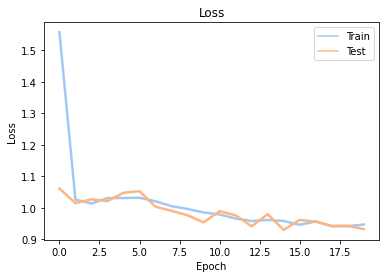

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


42/42 - 1s
8/8 - 0s
CNN MODEL WITH FILTER OF SIZE 5
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 47, 200)           8532000   
_________________________________________________________________
reshape_3 (Reshape)          (None, 47, 200, 1)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 43, 1, 256)        256256    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 1, 1, 256)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 256)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
de

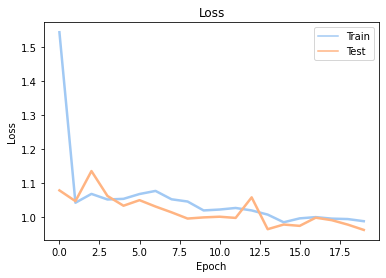

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


42/42 - 1s
8/8 - 0s
CNN MODEL WITH FILTER OF SIZE 7
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 47, 200)           8532000   
_________________________________________________________________
reshape_4 (Reshape)          (None, 47, 200, 1)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 41, 1, 256)        358656    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 1, 1, 256)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 256)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
de

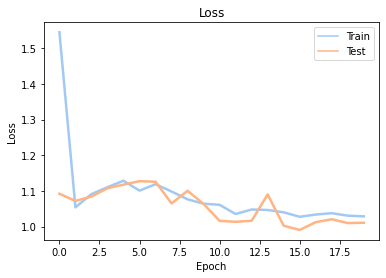

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


42/42 - 1s
8/8 - 0s
CNN MODEL WITH FILTER OF SIZE 9
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 47, 200)           8532000   
_________________________________________________________________
reshape_5 (Reshape)          (None, 47, 200, 1)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 39, 1, 256)        461056    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 1, 1, 256)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 256)               0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
de

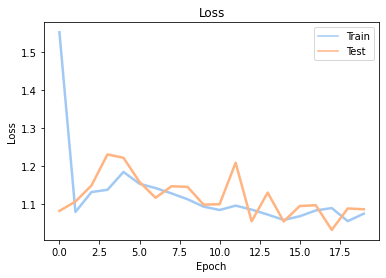

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


42/42 - 1s
8/8 - 0s
CNN MODEL WITH FILTER OF SIZE 11
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 47, 200)           8532000   
_________________________________________________________________
reshape_6 (Reshape)          (None, 47, 200, 1)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 37, 1, 256)        563456    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 1, 1, 256)         0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 256)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
d

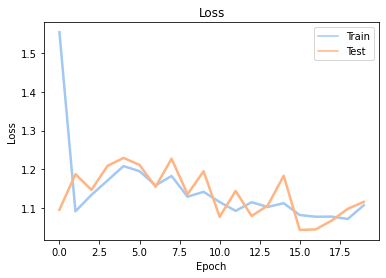

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


42/42 - 1s
8/8 - 0s


In [23]:
train_predictions = []
test_predictions = []

filter_sizes = [3,5,7,9,11]


for f in filter_sizes:
  print("CNN MODEL WITH FILTER OF SIZE {0}".format(f))
  model = cnn(f)

  history = model.fit(x=X_train, y=Y_train_cat, validation_data=(X_dev, Y_dev_cat), batch_size=1028, epochs=20, verbose=2)
  display_model_history(history)

    
  train_predictions.append(model.predict_classes([X_train], batch_size=1024, verbose=2))
  test_predictions.append(model.predict_classes([X_dev], batch_size=1024, verbose=2))


In [24]:
model.evaluate(X_train,Y_train_cat,batch_size=1028)

42/42 [==============================] - 1s 27ms/step - loss: 1.0687 - categorical_accuracy: 0.6677 - precision: 0.6908 - recall: 0.6247 - f1: 0.6561


[1.068670630455017,
 0.6676527261734009,
 0.6908039450645447,
 0.6246775388717651,
 0.6560879349708557]

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 5)]               0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 5)                 0         
_________________________________________________________________
dense_23 (Dense)             (None, 625)               3750      
_________________________________________________________________
dropout_17 (Dropout)         (None, 625)               0         
_________________________________________________________________
dense_24 (Dense)             (None, 100)               62600     
_________________________________________________________________
batch_normalization_3 (Batch (None, 100)               400       
_________________________________________________________________
dropout_18 (Dropout)         (None, 100)               0   

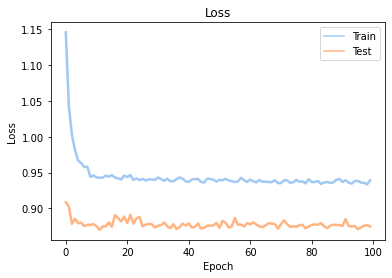

In [31]:
from keras.layers import BatchNormalization
def stack_models(predictions, targets):
    layer_size = len(predictions)
    inp = Input(shape=(layer_size,))
    d0 = Dropout(0.2)(inp)
    d0 = Dense(pow(layer_size, 4))(d0)
    d1 = Dropout(0.2)(d0)
    d1 = Dense(20 * layer_size)(d1)
    b = BatchNormalization()(d1)
    out = Dropout(0.2)(b)
    out = Dense(3, activation='sigmoid')(out)

    model = Model(inputs=inp, outputs=out)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=Metrics)
    model.summary()

    x = np.array(list(zip(*np.squeeze(predictions))))
    y = targets
    print(np.shape(x))
    print(np.shape(y))
    
    history = model.fit(x=x, y=y, epochs=100, validation_split=0.02, verbose=2)
    display_model_history(history) 
    return model
    
model = stack_models(test_predictions, Y_dev_cat)

stacked_test_predictions = np.array(list(zip(*np.squeeze(test_predictions))))
stacked_test_predictions = model.predict(stacked_test_predictions, batch_size=1024)

**Weighted Average Ensemble - Grid Search**

In [39]:

from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
from numpy import mean
from numpy import std
from numpy import array
from numpy import argmax
from numpy import tensordot
from numpy.linalg import norm
from itertools import product



In [41]:
def fit_model(filter_size, X_train, Y_train_cat):
  inputs = Input(shape=(sequence_length,), dtype='int32')
  embedding_layer = Embedding(input_dim=voc_size, output_dim=embedding_dim, weights = [embedding_matrix],input_length=sequence_length)(inputs)
  reshape = Reshape((sequence_length, embedding_dim, 1))(embedding_layer)
  conv_0 = Conv2D(64, kernel_size=(filter_size, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)
  conv_1 = Conv2D(64, kernel_size=(filter_size, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)
  maxpool_0 = MaxPool2D(pool_size=(sequence_length - filter_size + 1, 1), strides=(1,1), padding='valid')(conv_0)
  maxpool_1 = MaxPool2D(pool_size=(sequence_length - filter_size + 1, 1), strides=(1,1), padding='valid')(conv_1)
  concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1])
  flatten = Flatten()(concatenated_tensor)
  dropout = Dropout(0.5)(flatten)
  Dense_1 = Dense(units=135, activation='relu')(dropout)
  output = Dense(units=3, activation='softmax')(Dense_1)
  model = Model(inputs=inputs, outputs=output)
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=Metrics)
  model.summary()
  model.fit(X_train, Y_train_cat, epochs=10, batch_size=1028, verbose=2)
  return model

In [42]:
def ensemble_predictions(members, weights, testX):
	# make predictions
	yhats = [model.predict(testX) for model in members]
	yhats = array(yhats)
	# weighted sum across ensemble members
	summed = tensordot(yhats, weights, axes=((0),(0)))
	# argmax across classes
	result = argmax(summed, axis=1)
	return result

def evaluate_ensemble(members, weights, testX, testy):
	# make prediction
	yhat = ensemble_predictions(members, weights, testX)
	# calculate accuracy
	return accuracy_score(testy, yhat)
 
def normalize(weights):
	# calculate l1 vector norm
	result = norm(weights, 1)
	# check for a vector of all zeros
	if result == 0.0:
		return weights
	# return normalized vector (unit norm)
	return weights / result

def grid_search(members, testX, testy):
	# define weights to consider
	w = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
	best_score, best_weights = 0.0, None
	# iterate all possible combinations (cartesian product)
	for weights in product(w, repeat=len(members)):
		# skip if all weights are equal
		if len(set(weights)) == 1:
			continue
		# hack, normalize weight vector
		weights = normalize(weights)
		# evaluate weights
		score = evaluate_ensemble(members, weights, testX, testy)
		if score > best_score:
			best_score, best_weights = score, weights
			print('>%s %.3f' % (best_weights, best_score))

In [47]:
n_members = 5
members = [fit_model(3, X_train, Y_train_cat) for _ in range(n_members)]

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 47)]         0                                            
__________________________________________________________________________________________________
embedding_9 (Embedding)         (None, 47, 200)      8532000     input_14[0][0]                   
__________________________________________________________________________________________________
reshape_9 (Reshape)             (None, 47, 200, 1)   0           embedding_9[0][0]                
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 45, 1, 64)    38464       reshape_9[0][0]                  
____________________________________________________________________________________________

Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x7f784ef4e510>
Traceback (most recent call last):
  File "/usr/lib/python3.6/weakref.py", line 356, in remove
    def remove(k, selfref=ref(self)):
KeyboardInterrupt


42/42 - 6s - loss: 2.3552 - categorical_accuracy: 0.4466 - precision: 0.5592 - recall: 0.0126 - f1: 0.0066
Epoch 2/10
42/42 - 5s - loss: 1.0320 - categorical_accuracy: 0.4792 - precision: 0.7532 - recall: 0.0014 - f1: 0.0030
Epoch 3/10
42/42 - 5s - loss: 0.9987 - categorical_accuracy: 0.5640 - precision: 0.6796 - recall: 0.1762 - f1: 0.2575
Epoch 4/10
42/42 - 5s - loss: 0.9874 - categorical_accuracy: 0.5882 - precision: 0.6331 - recall: 0.4436 - f1: 0.5178
Epoch 5/10
42/42 - 5s - loss: 0.9816 - categorical_accuracy: 0.6029 - precision: 0.6430 - recall: 0.4880 - f1: 0.5559
Epoch 6/10
42/42 - 5s - loss: 0.9833 - categorical_accuracy: 0.6072 - precision: 0.6462 - recall: 0.5092 - f1: 0.5687
Epoch 7/10
42/42 - 5s - loss: 0.9856 - categorical_accuracy: 0.6116 - precision: 0.6518 - recall: 0.5174 - f1: 0.5751
Epoch 8/10
42/42 - 5s - loss: 0.9833 - categorical_accuracy: 0.6172 - precision: 0.6623 - recall: 0.5180 - f1: 0.5804
Epoch 9/10
42/42 - 5s - loss: 0.9722 - categorical_accuracy: 0.6243

In [50]:
weights = [1.0/n_members for _ in range(n_members)]
score = evaluate_ensemble(members, weights, X_dev, Y_dev)
print('Equal Weights Score: %.3f' % score)
# grid search weights
weights = grid_search(members, X_dev, Y_dev)
score = evaluate_ensemble(members, weights, X_dev, Y_dev)
print('Grid Search Weights: %s, Score: %.3f' % (weights, score))

Equal Weights Score: 0.647
>[0. 0. 0. 0. 1.] 0.609
>[0. 0. 0. 1. 0.] 0.634
>[0.  0.  0.  0.5 0.5] 0.644
>[0.         0.         0.         0.53333333 0.46666667] 0.644
>[0.         0.         0.         0.52941176 0.47058824] 0.645
>[0.         0.         0.         0.52631579 0.47368421] 0.645
>[0.  0.  0.5 0.  0.5] 0.646
>[0.         0.         0.33333333 0.33333333 0.33333333] 0.650
>[0.         0.         0.66666667 0.         0.33333333] 0.651


KeyboardInterrupt: ignored

**Soft Voting Ensemble**

In [51]:
import sklearn
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from matplotlib import pyplot

In [83]:
def new_cnn_model():
  num_classes = 3
  batch_size = 1028
  epochs = 20
  Y_train_cat = to_categorical(Y_train, 3)
  Y_dev_cat = to_categorical(Y_dev, 3)
  inputs = Input(shape=(sequence_length,), dtype='int32')
  embedding_layer = Embedding(input_dim=voc_size, output_dim=embedding_dim, weights = [embedding_matrix],input_length=sequence_length)(inputs)
  reshape = Reshape((sequence_length, embedding_dim, 1))(embedding_layer)
  conv_0 = Conv2D(124, kernel_size=(11, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)
  conv_1 = Conv2D(124, kernel_size=(11, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)
  maxpool_0 = MaxPool2D(pool_size=(sequence_length - 11 + 1, 1), strides=(1,1), padding='valid')(conv_0)
  maxpool_1 = MaxPool2D(pool_size=(sequence_length - 11 + 1, 1), strides=(1,1), padding='valid')(conv_1)
  concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1])
  flatten = Flatten()(concatenated_tensor)
  dropout = Dropout(0.5)(flatten)
  Dense_1 = Dense(units=256, activation='relu')(dropout)
  output = Dense(units=3, activation='softmax')(Dense_1)
  model_new_1 = Model(inputs=inputs, outputs=output)
  model_new_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=Metrics)
  model_new_1.fit(X_train, Y_train_cat, batch_size=batch_size, epochs=epochs,  validation_data=(X_dev, Y_dev_cat), shuffle=True)
  scores = model_new_1.evaluate(X_dev, Y_dev_cat, verbose=0)
  print("%s: %.2f%%" % (model_new_1.metrics_names[1], scores[1]*100))
  model_new_1.save("model_new_1.h5")
  print("Saved model to disk")
  return model_new_1

In [84]:
model_new_1 = new_cnn_model()

Epoch 1/20
42/42 [==============================] - 8s 168ms/step - loss: 3.5599 - categorical_accuracy: 0.5077 - precision: 0.6587 - recall: 0.1783 - f1: 0.0225 - val_loss: 1.1073 - val_categorical_accuracy: 0.4501 - val_precision: 0.5189 - val_recall: 0.2305 - val_f1: 0.3141
Epoch 2/20
42/42 [==============================] - 7s 159ms/step - loss: 1.0889 - categorical_accuracy: 0.4769 - precision: 0.5402 - recall: 0.0753 - f1: 0.1201 - val_loss: 1.1057 - val_categorical_accuracy: 0.4890 - val_precision: 0.5601 - val_recall: 0.3525 - val_f1: 0.4268
Epoch 3/20
42/42 [==============================] - 7s 159ms/step - loss: 1.1281 - categorical_accuracy: 0.5422 - precision: 0.6121 - recall: 0.2880 - f1: 0.3855 - val_loss: 1.1321 - val_categorical_accuracy: 0.5880 - val_precision: 0.7046 - val_recall: 0.3364 - val_f1: 0.4555
Epoch 4/20
42/42 [==============================] - 7s 160ms/step - loss: 1.1353 - categorical_accuracy: 0.5884 - precision: 0.6597 - recall: 0.3962 - f1: 0.4920 - va

In [78]:
def new_cnn_model_2():
  num_classes = 3
  batch_size = 1028
  epochs = 20
  Y_train_cat = to_categorical(Y_train, 3)
  Y_dev_cat = to_categorical(Y_dev, 3)
  inputs = Input(shape=(sequence_length,), dtype='int32')
  embedding_layer = Embedding(input_dim=voc_size, output_dim=embedding_dim, weights = [embedding_matrix],input_length=sequence_length)(inputs)
  reshape = Reshape((sequence_length, embedding_dim, 1))(embedding_layer)
  conv_0 = Conv2D(324, kernel_size=(9, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)
  conv_1 = Conv2D(324, kernel_size=(9, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)
  maxpool_0 = MaxPool2D(pool_size=(sequence_length - 9 + 1, 1), strides=(1,1), padding='valid')(conv_0)
  maxpool_1 = MaxPool2D(pool_size=(sequence_length - 9 + 1, 1), strides=(1,1), padding='valid')(conv_1)
  concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1])
  flatten = Flatten()(concatenated_tensor)
  dropout = Dropout(0.5)(flatten)
  Dense_1 = Dense(units=256, activation='relu')(dropout)
  output = Dense(units=3, activation='softmax')(Dense_1)
  model_new_2 = Model(inputs=inputs, outputs=output)
  model_new_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=Metrics)
  model_new_2.fit(X_train, Y_train_cat, batch_size=batch_size, epochs=epochs,  validation_data=(X_dev, Y_dev_cat), shuffle=True)
  scores = model_new_2.evaluate(X_dev, Y_dev_cat, verbose=0)
  print("%s: %.2f%%" % (model_new_2.metrics_names[1], scores[1]*100))
  model_new_2.save("model_new_2.h5")
  print("Saved model to disk")
  return model_new_2

In [80]:
model_new_2 = new_cnn_model_2()

Epoch 1/20
42/42 [==============================] - 13s 282ms/step - loss: 3.5371 - categorical_accuracy: 0.4801 - precision: 0.5628 - recall: 0.0413 - f1: 0.0286 - val_loss: 1.1320 - val_categorical_accuracy: 0.4507 - val_precision: 0.4773 - val_recall: 0.4094 - val_f1: 0.4391
Epoch 2/20
42/42 [==============================] - 12s 276ms/step - loss: 1.1114 - categorical_accuracy: 0.4873 - precision: 0.5233 - recall: 0.1328 - f1: 0.1771 - val_loss: 1.1360 - val_categorical_accuracy: 0.5110 - val_precision: 0.6789 - val_recall: 0.1967 - val_f1: 0.3079
Epoch 3/20
42/42 [==============================] - 11s 273ms/step - loss: 1.1399 - categorical_accuracy: 0.5441 - precision: 0.6184 - recall: 0.2872 - f1: 0.3831 - val_loss: 1.2205 - val_categorical_accuracy: 0.5862 - val_precision: 0.6009 - val_recall: 0.5475 - val_f1: 0.5734
Epoch 4/20
42/42 [==============================] - 11s 271ms/step - loss: 1.2402 - categorical_accuracy: 0.5770 - precision: 0.6162 - recall: 0.4461 - f1: 0.5145 

In [76]:
def new_cnn_model_3():
  num_classes = 3
  batch_size = 1028
  epochs = 20
  Y_train_cat = to_categorical(Y_train, 3)
  Y_dev_cat = to_categorical(Y_dev, 3)
  inputs = Input(shape=(sequence_length,), dtype='int32')
  embedding_layer = Embedding(input_dim=voc_size, output_dim=embedding_dim, weights = [embedding_matrix],input_length=sequence_length)(inputs)
  reshape = Reshape((sequence_length, embedding_dim, 1))(embedding_layer)
  conv_0 = Conv2D(552, kernel_size=(7, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)
  conv_1 = Conv2D(552, kernel_size=(7, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)
  maxpool_0 = MaxPool2D(pool_size=(sequence_length - 7 + 1, 1), strides=(1,1), padding='valid')(conv_0)
  maxpool_1 = MaxPool2D(pool_size=(sequence_length - 7 + 1, 1), strides=(1,1), padding='valid')(conv_1)
  concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1])
  flatten = Flatten()(concatenated_tensor)
  dropout = Dropout(0.5)(flatten)
  Dense_1 = Dense(units=256, activation='relu')(dropout)
  output = Dense(units=3, activation='softmax')(Dense_1)
  model_new_3 = Model(inputs=inputs, outputs=output)
  model_new_3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=Metrics)
  model_new_3.fit(X_train, Y_train_cat, batch_size=batch_size, epochs=epochs,  validation_data=(X_dev, Y_dev_cat), shuffle=True)
  scores = model_new_3.evaluate(X_dev, Y_dev_cat, verbose=0)
  print("%s: %.2f%%" % (model_new_3.metrics_names[1], scores[1]*100))
  model_new_3.save("model_new_3.h5")
  print("Saved model to disk")
  return model_new_3

In [77]:
model_new_3 = new_cnn_model_3()

Epoch 1/20
42/42 [==============================] - 16s 356ms/step - loss: 3.5785 - categorical_accuracy: 0.4946 - precision: 0.6422 - recall: 0.1942 - f1: 0.0195 - val_loss: 1.1286 - val_categorical_accuracy: 0.5532 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_f1: 0.0000e+00
Epoch 2/20
42/42 [==============================] - 15s 355ms/step - loss: 1.1026 - categorical_accuracy: 0.5016 - precision: 0.5184 - recall: 0.0716 - f1: 0.1053 - val_loss: 1.1790 - val_categorical_accuracy: 0.4716 - val_precision: 0.5489 - val_recall: 0.2920 - val_f1: 0.3856
Epoch 3/20
42/42 [==============================] - 15s 348ms/step - loss: 1.1403 - categorical_accuracy: 0.5454 - precision: 0.6105 - recall: 0.3435 - f1: 0.4354 - val_loss: 1.2603 - val_categorical_accuracy: 0.4925 - val_precision: 0.5477 - val_recall: 0.3116 - val_f1: 0.4014
Epoch 4/20
42/42 [==============================] - 14s 344ms/step - loss: 1.2142 - categorical_accuracy: 0.5728 - precision: 0.6229 - recall: 0.4269 -

In [74]:
def new_cnn_model_4():
  num_classes = 3
  batch_size = 1028
  epochs = 20
  Y_train_cat = to_categorical(Y_train, 3)
  Y_dev_cat = to_categorical(Y_dev, 3)
  inputs = Input(shape=(sequence_length,), dtype='int32')
  embedding_layer = Embedding(input_dim=voc_size, output_dim=embedding_dim, weights = [embedding_matrix],input_length=sequence_length)(inputs)
  reshape = Reshape((sequence_length, embedding_dim, 1))(embedding_layer)
  conv_0 = Conv2D(600, kernel_size=(5, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)
  conv_1 = Conv2D(600, kernel_size=(5, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)
  maxpool_0 = MaxPool2D(pool_size=(sequence_length - 5 + 1, 1), strides=(1,1), padding='valid')(conv_0)
  maxpool_1 = MaxPool2D(pool_size=(sequence_length - 5 + 1, 1), strides=(1,1), padding='valid')(conv_1)
  concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1])
  flatten = Flatten()(concatenated_tensor)
  dropout = Dropout(0.5)(flatten)
  Dense_1 = Dense(units=256, activation='relu')(dropout)
  output = Dense(units=3, activation='softmax')(Dense_1)
  model_new_4 = Model(inputs=inputs, outputs=output)
  model_new_4.compile(loss='categorical_crossentropy', optimizer='adam', metrics=Metrics)
  model_new_4.fit(X_train, Y_train_cat, batch_size=batch_size, epochs=epochs,  validation_data=(X_dev, Y_dev_cat), shuffle=True)
  scores = model_new_4.evaluate(X_dev, Y_dev_cat, verbose=0)
  print("%s: %.2f%%" % (model_new_4.metrics_names[1], scores[1]*100))
  model_new_4.save("model_new_4.h5")
  print("Saved model to disk")
  return model_new_4

In [75]:
model_new_4 = new_cnn_model_4()

Epoch 1/20
42/42 [==============================] - 15s 323ms/step - loss: 3.5349 - categorical_accuracy: 0.5095 - precision: 0.6501 - recall: 0.1922 - f1: 0.0200 - val_loss: 1.1173 - val_categorical_accuracy: 0.3917 - val_precision: 0.6385 - val_recall: 0.1298 - val_f1: 0.2183
Epoch 2/20
42/42 [==============================] - 13s 311ms/step - loss: 1.0838 - categorical_accuracy: 0.4711 - precision: 0.5703 - recall: 0.0950 - f1: 0.1403 - val_loss: 1.1029 - val_categorical_accuracy: 0.5936 - val_precision: 0.6954 - val_recall: 0.3290 - val_f1: 0.4455
Epoch 3/20
42/42 [==============================] - 13s 312ms/step - loss: 1.1056 - categorical_accuracy: 0.5690 - precision: 0.6230 - recall: 0.3820 - f1: 0.4694 - val_loss: 1.1065 - val_categorical_accuracy: 0.5986 - val_precision: 0.6958 - val_recall: 0.3549 - val_f1: 0.4717
Epoch 4/20
42/42 [==============================] - 13s 308ms/step - loss: 1.1321 - categorical_accuracy: 0.5914 - precision: 0.6377 - recall: 0.4543 - f1: 0.5292 

In [69]:
def new_cnn_model_5():
  num_classes = 3
  batch_size = 1028
  epochs = 20
  Y_train_cat = to_categorical(Y_train, 3)
  Y_dev_cat = to_categorical(Y_dev, 3)
  inputs = Input(shape=(sequence_length,), dtype='int32')
  embedding_layer = Embedding(input_dim=voc_size, output_dim=embedding_dim, weights = [embedding_matrix],input_length=sequence_length)(inputs)
  reshape = Reshape((sequence_length, embedding_dim, 1))(embedding_layer)
  conv_0 = Conv2D(824, kernel_size=(3, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)
  conv_1 = Conv2D(824, kernel_size=(3, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)
  maxpool_0 = MaxPool2D(pool_size=(sequence_length - 3 + 1, 1), strides=(1,1), padding='valid')(conv_0)
  maxpool_1 = MaxPool2D(pool_size=(sequence_length - 3 + 1, 1), strides=(1,1), padding='valid')(conv_1)
  concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1])
  flatten = Flatten()(concatenated_tensor)
  dropout = Dropout(0.5)(flatten)
  Dense_1 = Dense(units=256, activation='relu')(dropout)
  output = Dense(units=3, activation='softmax')(Dense_1)
  model_new_5 = Model(inputs=inputs, outputs=output)
  model_new_5.compile(loss='categorical_crossentropy', optimizer='adam', metrics=Metrics)
  model_new_5.fit(X_train, Y_train_cat, batch_size=batch_size, epochs=epochs,  validation_data=(X_dev, Y_dev_cat), shuffle=True)
  scores = model_new_5.evaluate(X_dev, Y_dev_cat, verbose=0)
  print("%s: %.2f%%" % (model_new_5.metrics_names[1], scores[1]*100))
  model_new_5.save("model_new_5.h5")
  print("Saved model to disk")
  return model_new_5

In [70]:
model_new_5 = new_cnn_model_5()

Epoch 1/20
42/42 [==============================] - 14s 320ms/step - loss: 3.5226 - categorical_accuracy: 0.4483 - precision: 0.4566 - recall: 0.0051 - f1: 0.0087 - val_loss: 1.1092 - val_categorical_accuracy: 0.3918 - val_precision: 0.5834 - val_recall: 0.2509 - val_f1: 0.3535
Epoch 2/20
42/42 [==============================] - 13s 314ms/step - loss: 1.0675 - categorical_accuracy: 0.5260 - precision: 0.6225 - recall: 0.2217 - f1: 0.3014 - val_loss: 1.0709 - val_categorical_accuracy: 0.5947 - val_precision: 0.7169 - val_recall: 0.3270 - val_f1: 0.4463
Epoch 3/20
42/42 [==============================] - 13s 313ms/step - loss: 1.0687 - categorical_accuracy: 0.5967 - precision: 0.6478 - recall: 0.4348 - f1: 0.5176 - val_loss: 1.1165 - val_categorical_accuracy: 0.5908 - val_precision: 0.6528 - val_recall: 0.4425 - val_f1: 0.5264
Epoch 4/20
42/42 [==============================] - 13s 316ms/step - loss: 1.1180 - categorical_accuracy: 0.5937 - precision: 0.6334 - recall: 0.4781 - f1: 0.5436 

In [85]:
def new_cnn_model_6():
  num_classes = 3
  batch_size = 1028
  epochs = 20
  Y_train_cat = to_categorical(Y_train, 3)
  Y_dev_cat = to_categorical(Y_dev, 3)
  inputs = Input(shape=(sequence_length,), dtype='int32')
  embedding_layer = Embedding(input_dim=voc_size, output_dim=embedding_dim, weights = [embedding_matrix],input_length=sequence_length)(inputs)
  reshape = Reshape((sequence_length, embedding_dim, 1))(embedding_layer)
  conv_0 = Conv2D(1024, kernel_size=(3, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)
  conv_1 = Conv2D(1024, kernel_size=(3, embedding_dim), activation='relu', kernel_regularizer=regularizers.l2(3))(reshape)
  maxpool_0 = MaxPool2D(pool_size=(sequence_length - 3 + 1, 1), strides=(1,1), padding='valid')(conv_0)
  maxpool_1 = MaxPool2D(pool_size=(sequence_length - 3 + 1, 1), strides=(1,1), padding='valid')(conv_1)
  concatenated_tensor = Concatenate(axis=1)([maxpool_0, maxpool_1])
  flatten = Flatten()(concatenated_tensor)
  dropout = Dropout(0.5)(flatten)
  Dense_1 = Dense(units=256, activation='relu')(dropout)
  output = Dense(units=3, activation='softmax')(Dense_1)
  model_new_6 = Model(inputs=inputs, outputs=output)
  model_new_6.compile(loss='categorical_crossentropy', optimizer='adam', metrics=Metrics)
  model_new_6.fit(X_train, Y_train_cat, batch_size=batch_size, epochs=epochs,  validation_data=(X_dev, Y_dev_cat), shuffle=True)
  scores = model_new_6.evaluate(X_dev, Y_dev_cat, verbose=0)
  print("%s: %.2f%%" % (model_new_6.metrics_names[1], scores[1]*100))
  model_new_6.save("model_new_6.h5")
  print("Saved model to disk")
  return model_new_6

In [86]:
model_new_6 = new_cnn_model_6()

Epoch 1/20
42/42 [==============================] - 17s 372ms/step - loss: 3.5273 - categorical_accuracy: 0.5082 - precision: 0.6584 - recall: 0.1847 - f1: 0.0189 - val_loss: 1.1148 - val_categorical_accuracy: 0.5566 - val_precision: 0.7468 - val_recall: 0.1262 - val_f1: 0.2163
Epoch 2/20
42/42 [==============================] - 16s 371ms/step - loss: 1.0822 - categorical_accuracy: 0.5351 - precision: 0.6184 - recall: 0.2406 - f1: 0.3204 - val_loss: 1.0815 - val_categorical_accuracy: 0.5953 - val_precision: 0.6361 - val_recall: 0.4937 - val_f1: 0.5548
Epoch 3/20
42/42 [==============================] - 16s 374ms/step - loss: 1.0923 - categorical_accuracy: 0.5933 - precision: 0.6361 - recall: 0.4560 - f1: 0.5282 - val_loss: 1.0807 - val_categorical_accuracy: 0.5987 - val_precision: 0.6563 - val_recall: 0.4629 - val_f1: 0.5418
Epoch 4/20
42/42 [==============================] - 15s 364ms/step - loss: 1.0936 - categorical_accuracy: 0.6015 - precision: 0.6413 - recall: 0.4857 - f1: 0.5520 

In [106]:
def get_voting():
  models = list()
  models.append(('cnn1', model_new_1))
  models.append(('cnn2', model_new_2))
  models.append(('cnn3', model_new_3))
  models.append(('cnn4', model_new_4))
  models.append(('cnn5', model_new_5))
  #models.append(('cnn6', model_new_6))
	# define the voting ensemble
  ensemble = VotingClassifier(estimators=models, voting='soft')
  return ensemble

def get_models():
	models = dict()
	models['cnn1'] = model_new_1
	models['cnn2'] = model_new_2
	models['cnn3'] = model_new_3
	models['cnn4'] = model_new_4
	models['cnn5'] = model_new_5
  #models['cnn6'] = model_new_6
	models['soft_voting'] = get_voting()
	return models

def evaluate_model(model, X, y):
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
	return scores


In [119]:
y_train_array = np.array(Y_train)

In [120]:
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X_train, y_train_array)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

TypeError: ignored